This example examines output from the `elm-pb` example included in the `BOUT-dev` repo. \[It was tested with output from the `next` branch at commit df7c980c3bec3adee17067a3dd9190c2ff79f0db\].

You can use it in two ways, either generate the data or download it. Generate by running `elm-pb` and then copying its `BOUT.inp` (input file), `cbm18_dens8.grid_nx68ny64.nc` (grid file) and `BOUT.dmp.*.nc` (output files) to the directory containing this notebook. Download by running the first Python cell in the 'Setup' section.

Contents:
* Setup
* Load
* Plot
* Animate
* Extras

Setup
=====

In [1]:
# Download data files if you do not have them already
from pathlib import Path
import urllib.request
for filename in ["BOUT.inp", "cbm18_dens8.grid_nx68ny64.nc", "BOUT.dmp.0.nc"]:
    if not Path(filename).exists():
        urllib.request.urlretrieve(f"https://zenodo.org/record/4295926/files/{filename}?download=1", filename)

In [2]:
# set up matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({'font.size': 14})

In [3]:
import numpy as np
from xbout import open_boutdataset

Load
====

First we need to open the Dataset.

The chunks argument to `open_boutdataset()` is needed so that dask can parallelise
operations over the time dimension (by default the chunk size is the size of the
arrays in the files being loaded). See
http://xarray.pydata.org/en/stable/dask.html#chunking-and-performance.

The geometry argument is needed to allow poloidal plots to be made (see below).
The gridfile is required to provide Rxy, Zxy and psixy arrays to set up the geometry

In [4]:
ds = open_boutdataset(chunks={"t": 1}, geometry="toroidal", gridfilepath="cbm18_dens8.grid_nx68ny64.nc")

# elm-pb saves aligned fields. We want to plot non-aligned, so transform.
# Saving aligned fields is a non-default option, used for backward compatibility, so most models will not need this.
for var in ["U", "P", "Psi"]:
    ds[var] = ds[var].bout.from_field_aligned()

Applying toroidal geometry conventions
Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset>
Dimensions:       (t: 41, theta: 64, x: 68, zeta: 16)
Coordinates:
    zShift        (x, theta) float64 dask.array<chunksize=(68, 64), meta=np.ndarray>
    psi_poloidal  (x, theta) float64 -0.4824 -0.4824 -0.4824 ... 0.2573 0.2573
    R             (x, theta) float64 2.929 2.932 2.941 ... 1.998 1.962 1.941
    Z             (x, theta) float64 6.261e-08 0.07125 ... -0.3126 -0.1568
  * t             (t) float64 0.0 1.0 2.0 3.0 4.0 ... 36.0 37.0 38.0 39.0 40.0
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 ... 59 60 61 62 63 64 65 66 67
  * theta         (theta) float64 0.04909 0.1473 0.2454 ... 6.038 6.136 6.234
  * zeta          (zeta) float64 0.0 0.02618 0.05236 ... 0.3403 0.3665 0.3927
Data variables:
    dx            (x, theta) float64 dask.array<chunksize=(68, 64), meta=np.ndarray>
    dy            (x, theta) float64 dask.array<chunksize=(68, 64), meta=np.ndarray>
    g11           (x, 

The poloidal coordinate is the one used as a parallel coordinate,
so has relatively low resolution because we assume that all structures
are field-aligned with much smaller parallel gradients than perpendicular
gradients.
We can use this property to increase the poloidal resolution by
transforming to field-aligned coordinates, interpolating in the parallel
direction to increase parallel resolution, and finally transforming back
to the non-aligned coordinates. This makes nicer poloidal-plane plots
(see below).

In [5]:
ds_highres = ds.bout.interpolate_parallel(..., n=10)

Plot
===

Make some plots of the final state of the simulation.

In [6]:
ds_final = ds.isel(t=-1)

First we look at some radial-toroidal plots.

Note: the dimensions when using the geometry="toroidal" option are named
"x" (radial dimension), "theta" (poloidal angle) and "zeta" (toroidal angle).
They are renamed from the "x", "y", "z" dimensions in BOUT++ output files
within the function that sets up toroidal geometry, called from
`open_boutdataset()`.

Here we use xarray methods to plot simple slices.

<IPython.core.display.Javascript object>


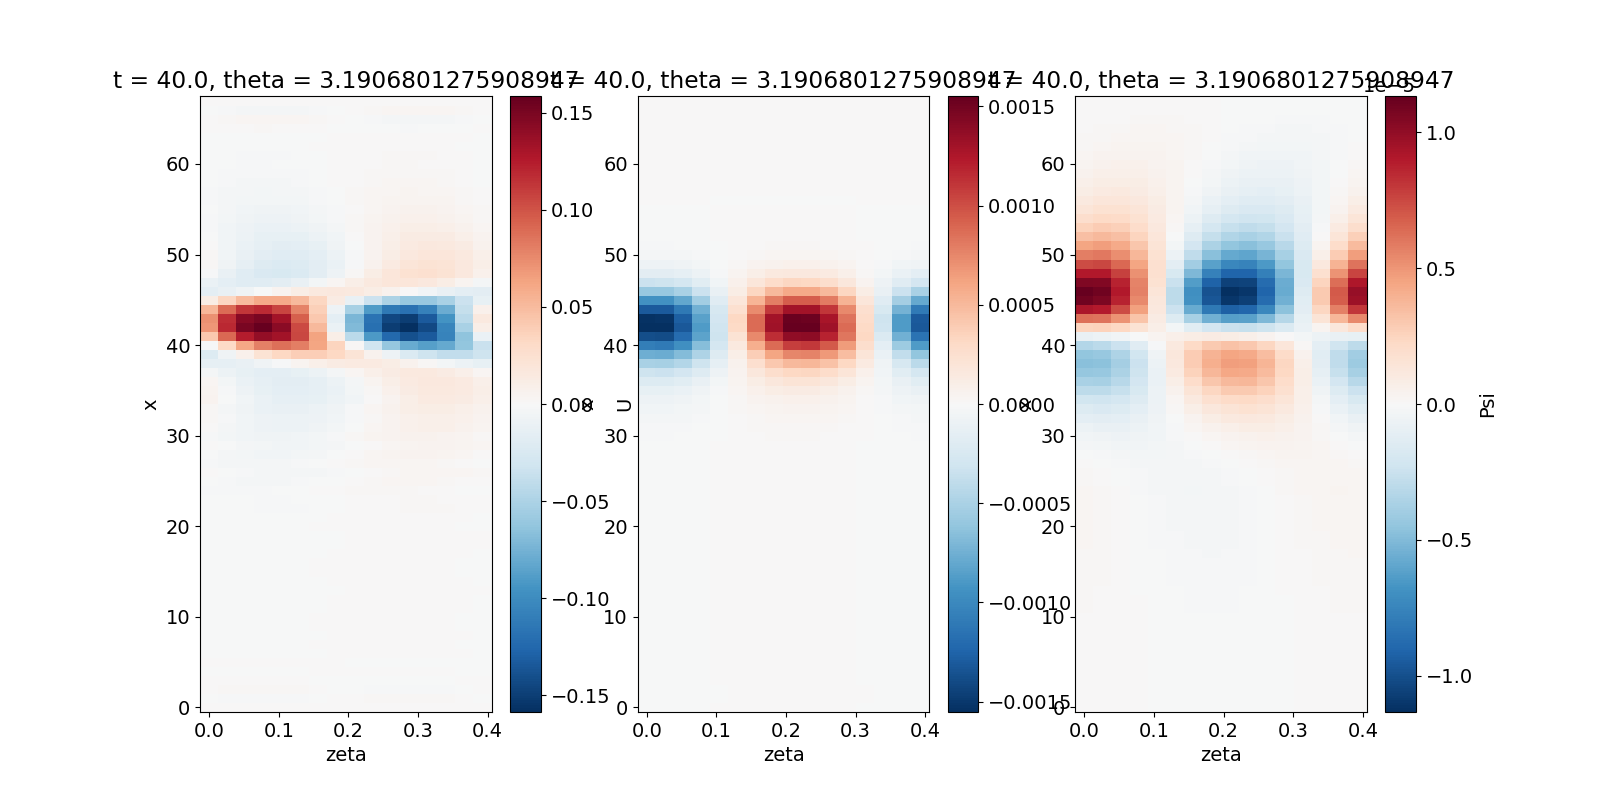

In [7]:
plt.figure()
plt.subplot(131)
ds_final.isel(theta=32)["U"].plot()
plt.subplot(132)
ds_final.isel(theta=32)["P"].plot()
plt.subplot(133)
ds_final.isel(theta=32)["Psi"].plot()

Now use an `xbout` method to make a plot in the poloidal plane.

The method is called through the `.bout` 'accessor'. It takes account
of geometry, plotting in poloidal plane.

`xbout` plot calls include the call to  `plt.figure()`, so no need to
create new figures separately.

Notice the plots look blocky because of the low poloidal resolution.

<IPython.core.display.Javascript object>


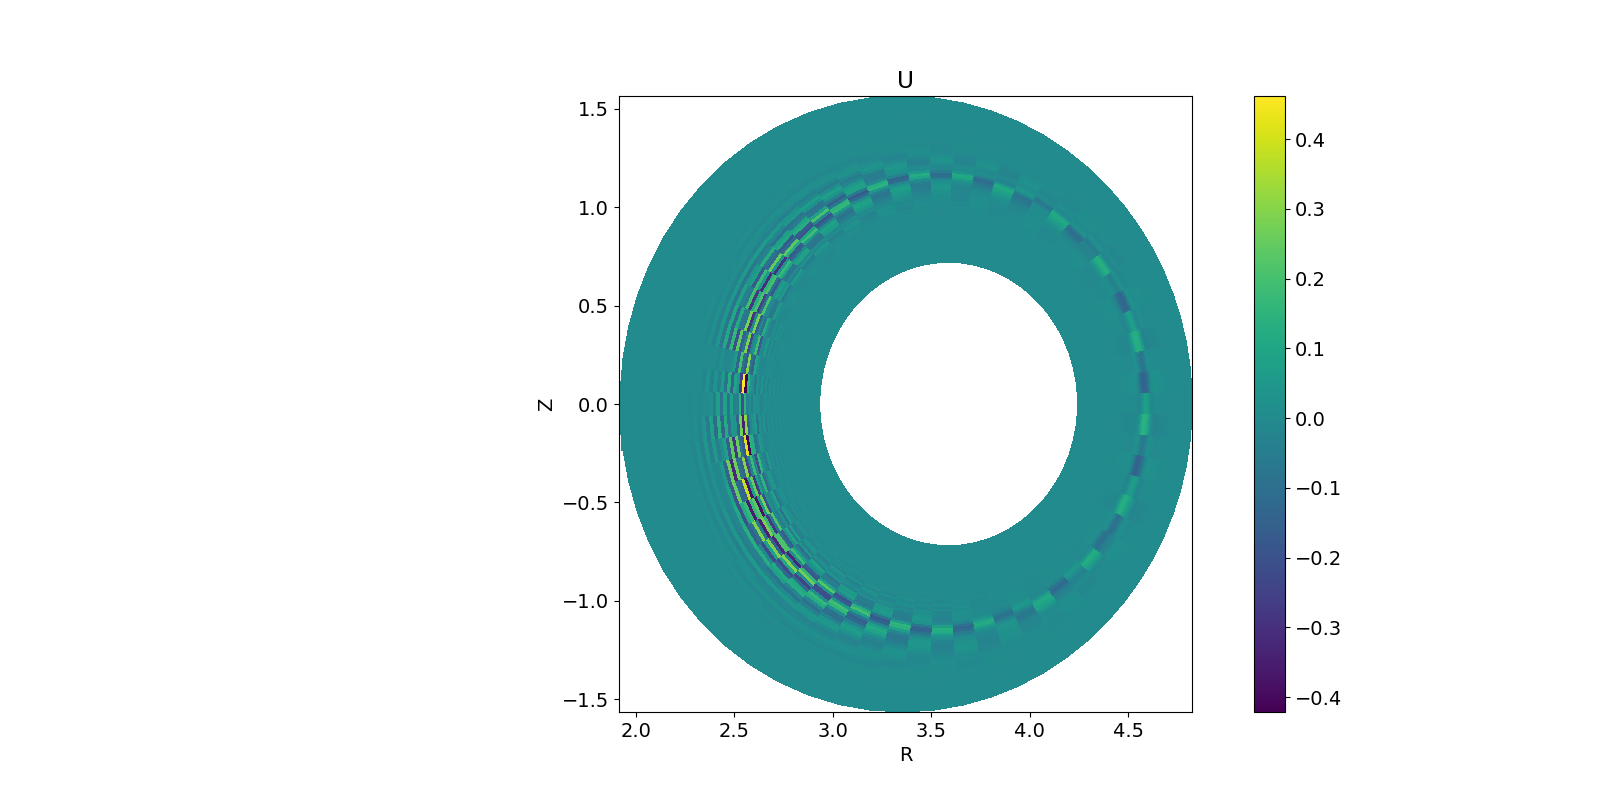

<IPython.core.display.Javascript object>


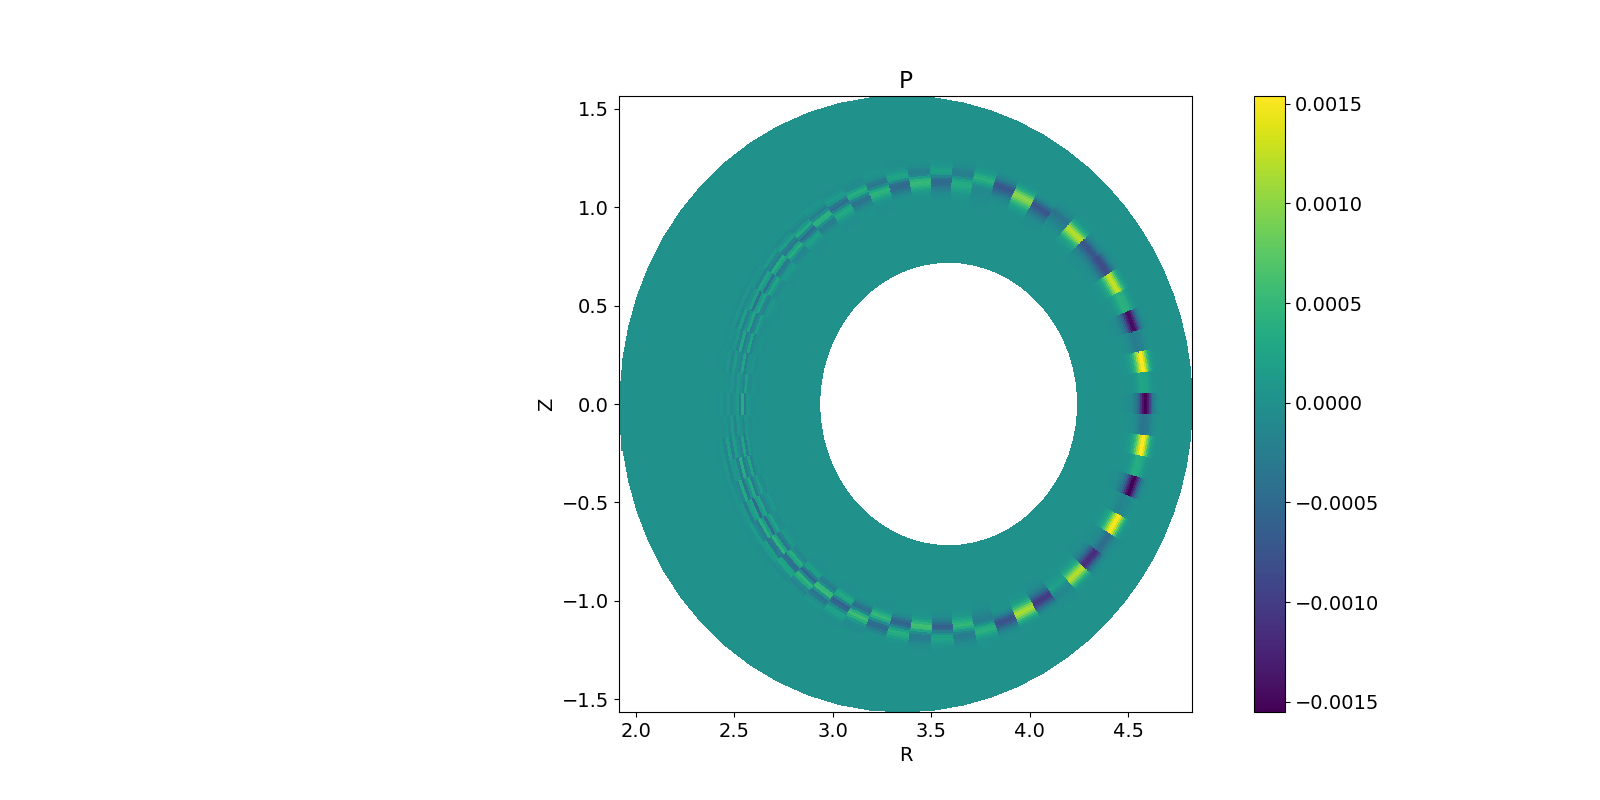

<IPython.core.display.Javascript object>


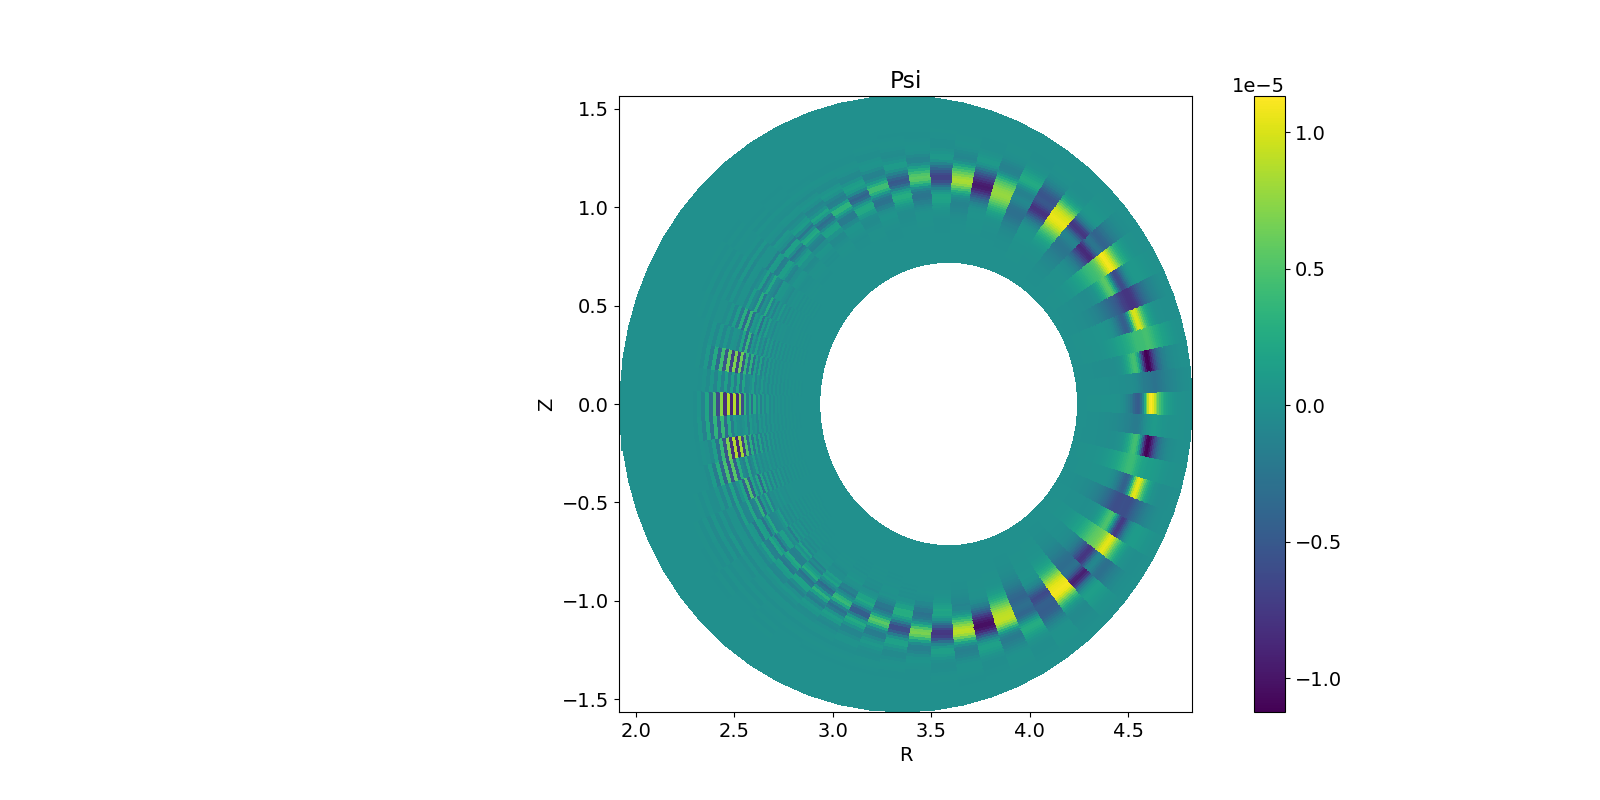

In [8]:
ds_final.isel(zeta=0)["U"].bout.pcolormesh()
ds_final.isel(zeta=0)["P"].bout.pcolormesh()
ds_final.isel(zeta=0)["Psi"].bout.pcolormesh()

Using the dataset with high poloidal resolution created above using
interpolation in the parallel direction, we get smoother, more detailed
plots of the structure in the poloidal plane.

<IPython.core.display.Javascript object>


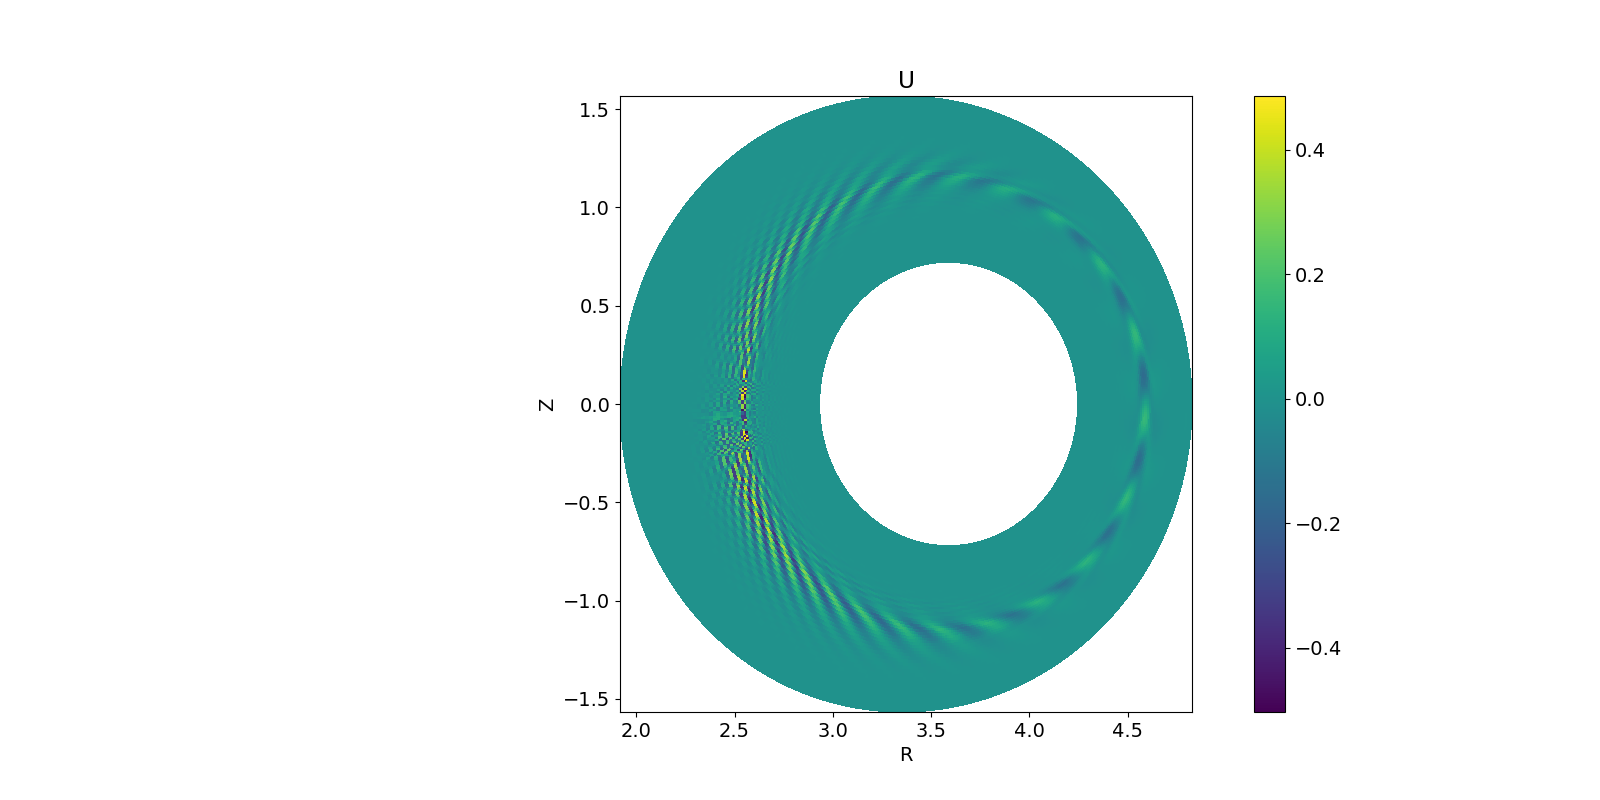

<IPython.core.display.Javascript object>


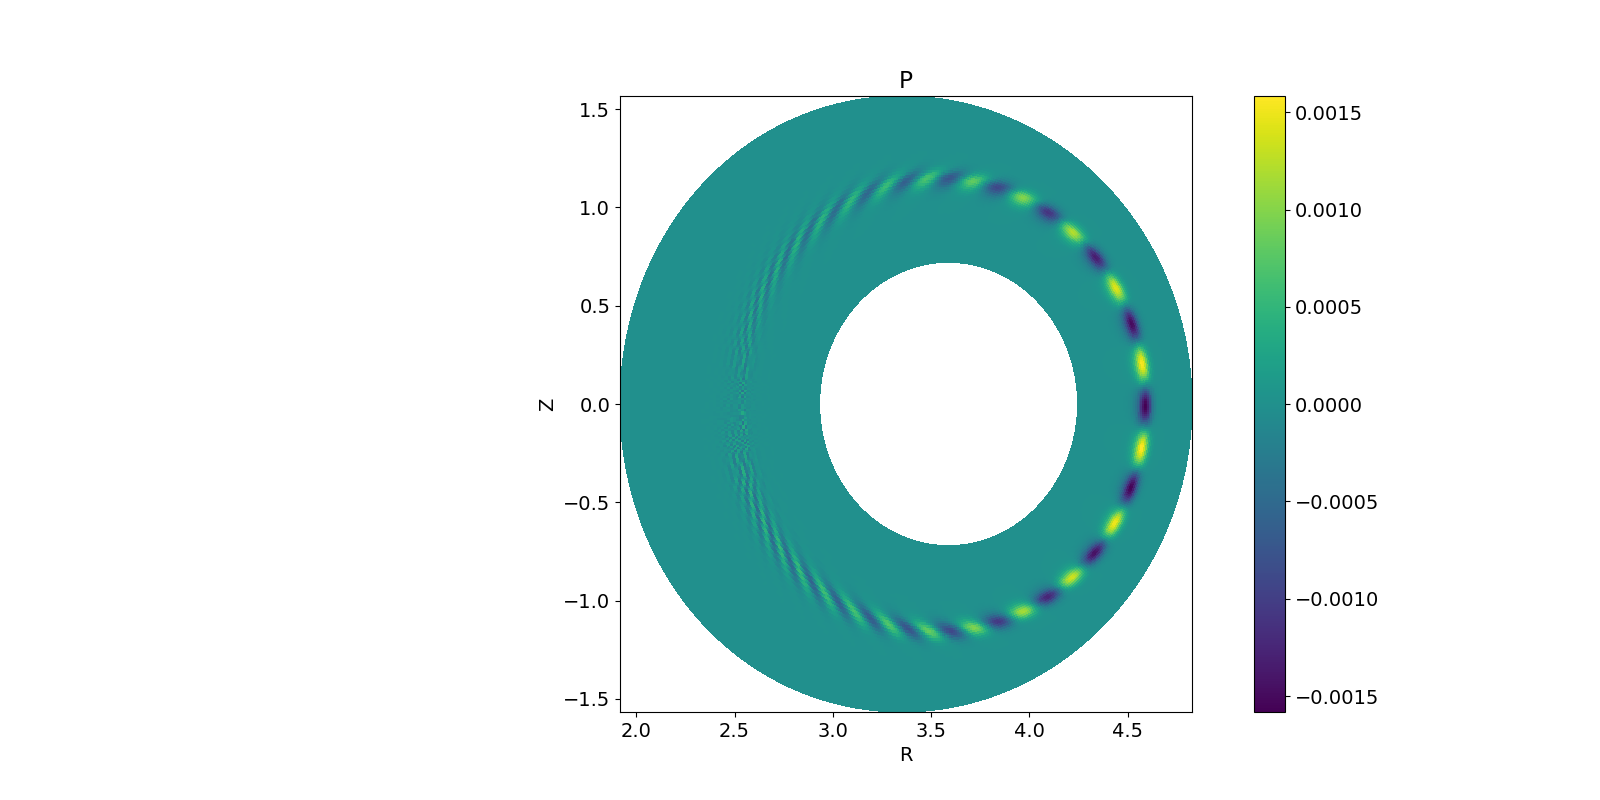

<IPython.core.display.Javascript object>


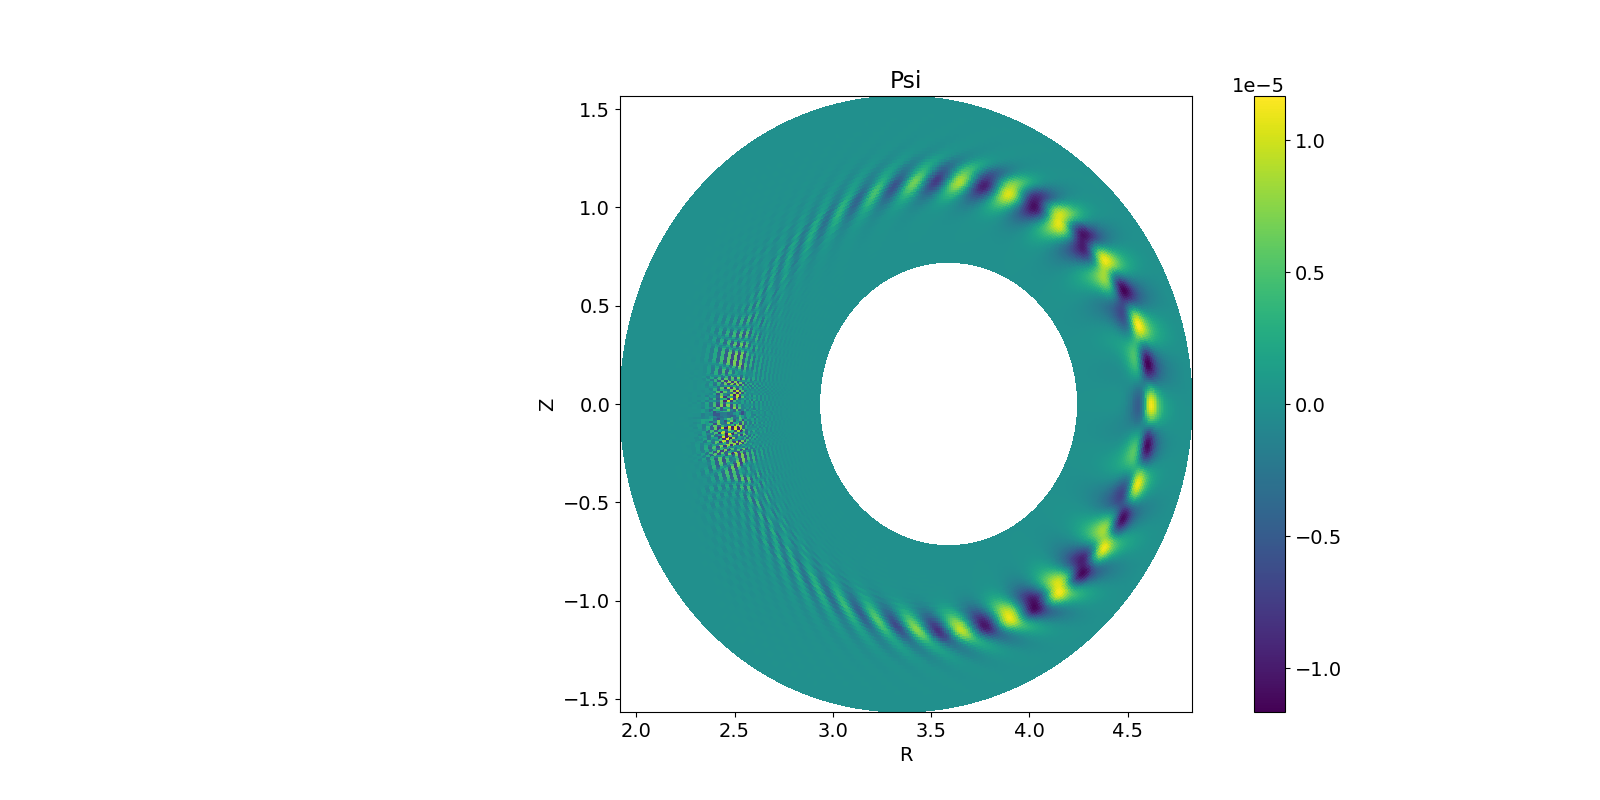

In [9]:
ds_highres.isel(t=-1, zeta=0)["U"].bout.pcolormesh()
ds_highres.isel(t=-1, zeta=0)["P"].bout.pcolormesh()
ds_highres.isel(t=-1, zeta=0)["Psi"].bout.pcolormesh()

Even smoother plots can be made by using the `shading="gouraud"`
option to apply linear interpolation between the grid points when
making the plot.

<IPython.core.display.Javascript object>


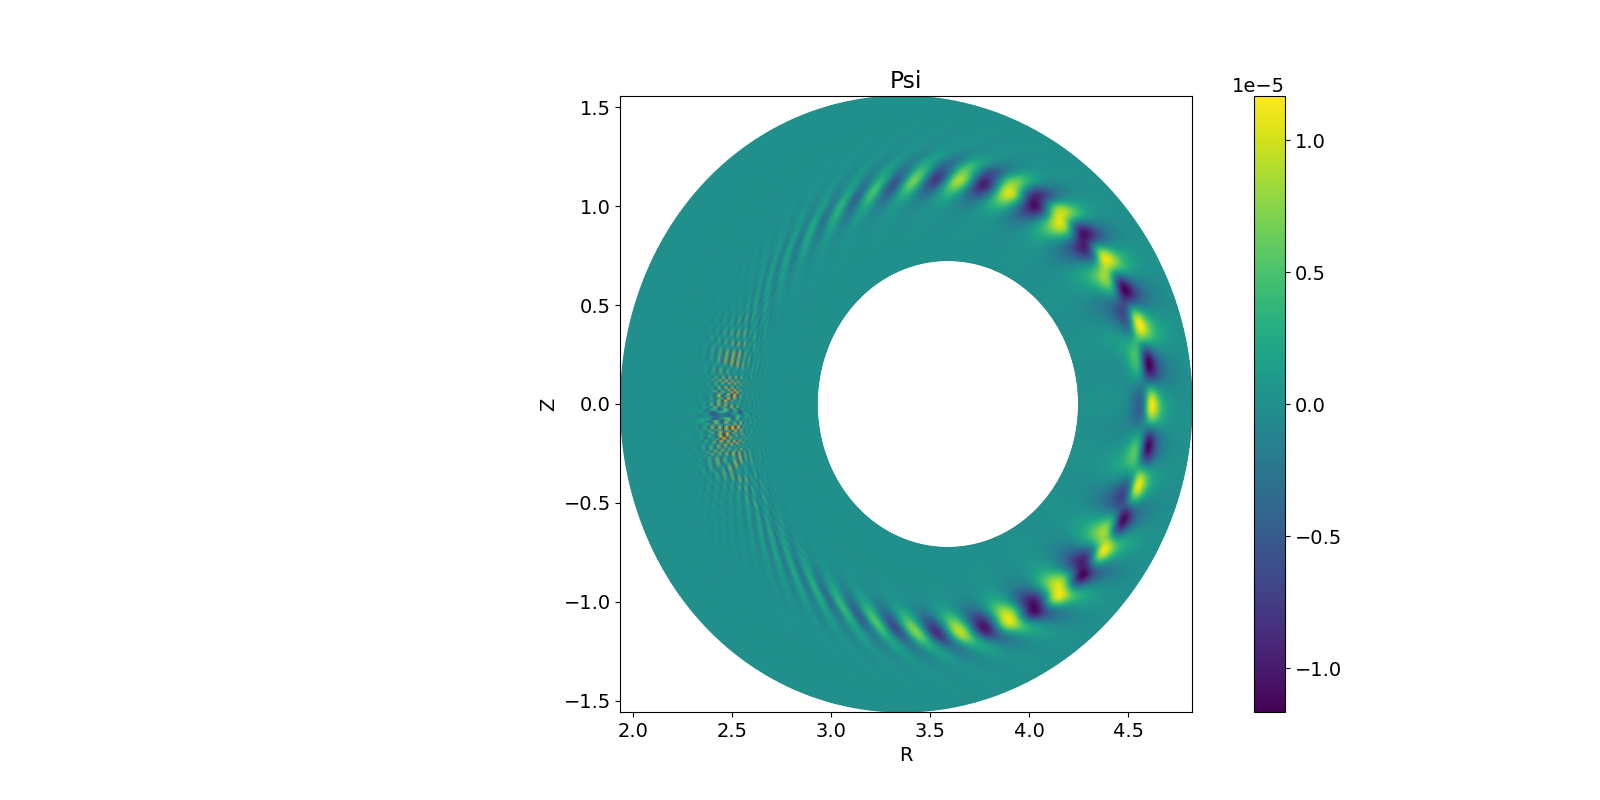

In [10]:
ds_highres.isel(t=-1, zeta=0)["Psi"].bout.pcolormesh(shading="gouraud")

We can choose a different slice to make plots on a flux-surface

<IPython.core.display.Javascript object>


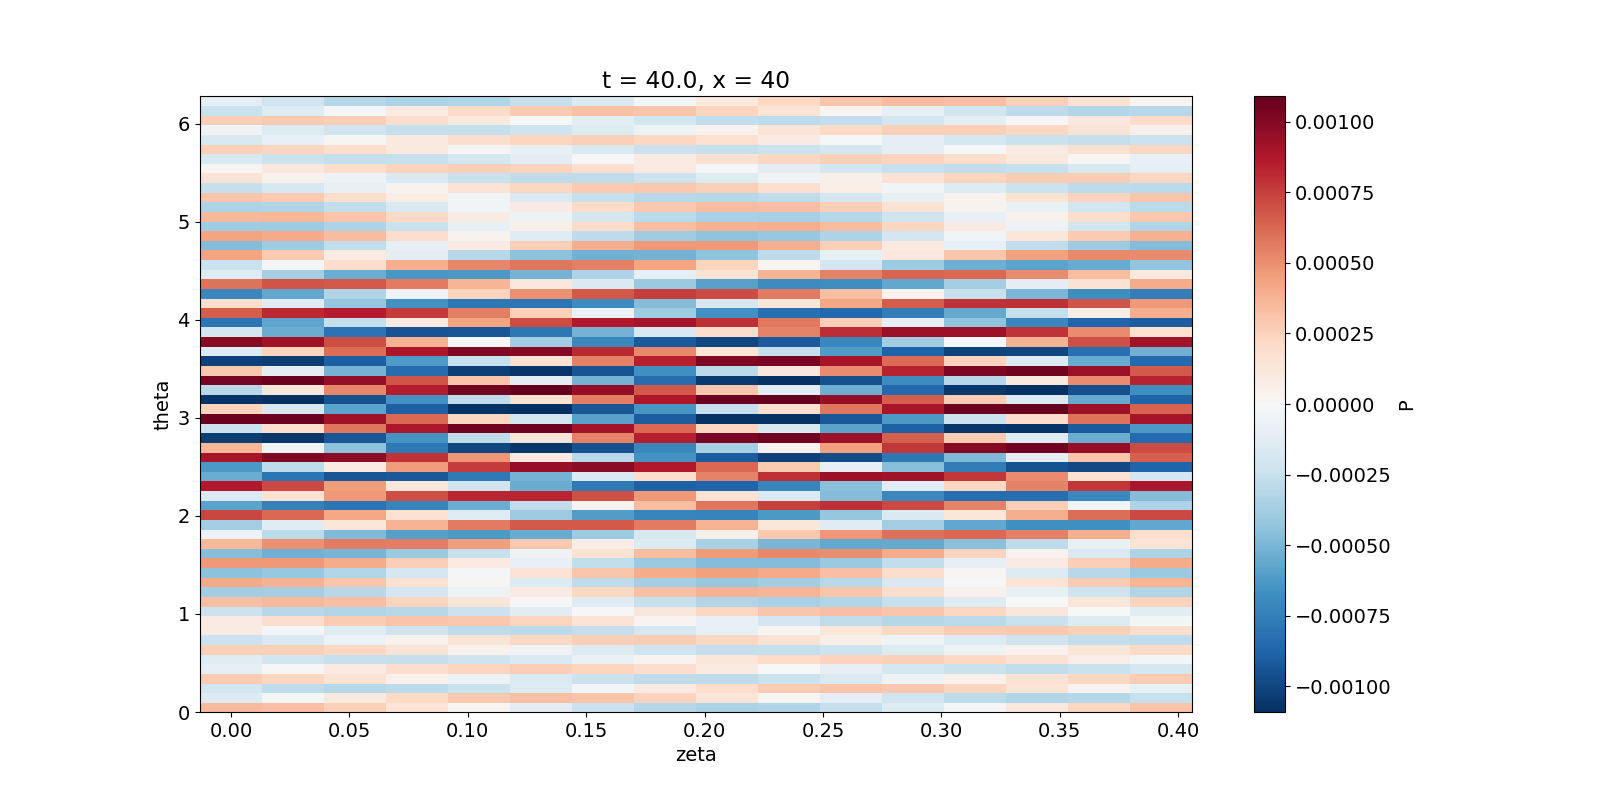

In [11]:
plt.figure()
ds["P"].isel(t=-1, x=40).plot()

Again, using the interpolated Dataset gives smoother, more detailed
plots.

<IPython.core.display.Javascript object>


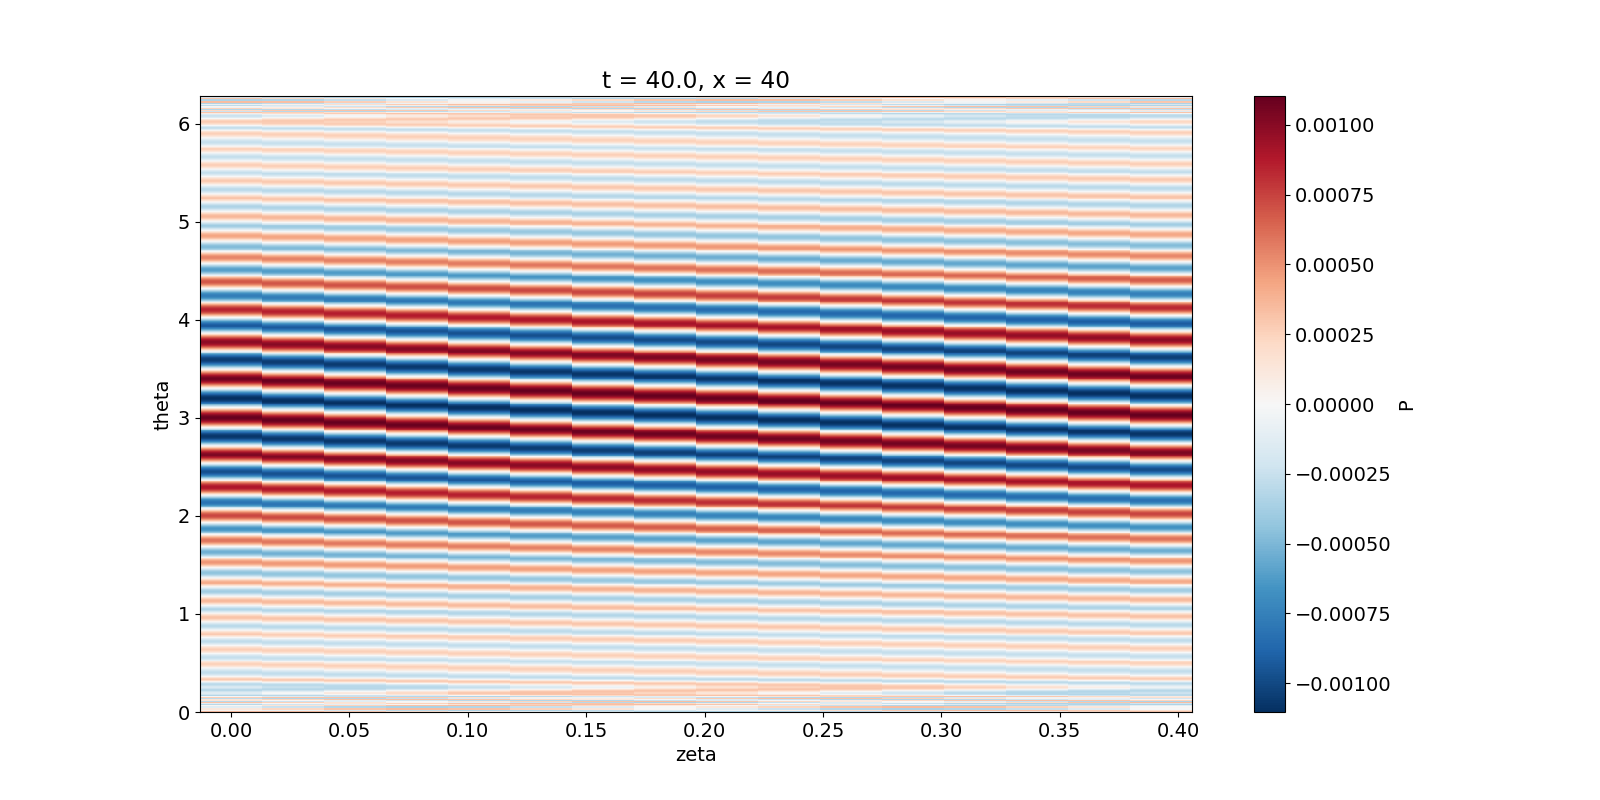

In [12]:
plt.figure()
ds_highres["P"].isel(t=-1, x=40).plot()

Smoother plotting using linear interpolation with `shading="gouraud"`.
When not passing coordinates explicitly to xarray's plot method (which
`xbout` methods do internally), using this option requires
`infer_intervals=False` (see https://github.com/pydata/xarray/issues/3002).

<IPython.core.display.Javascript object>


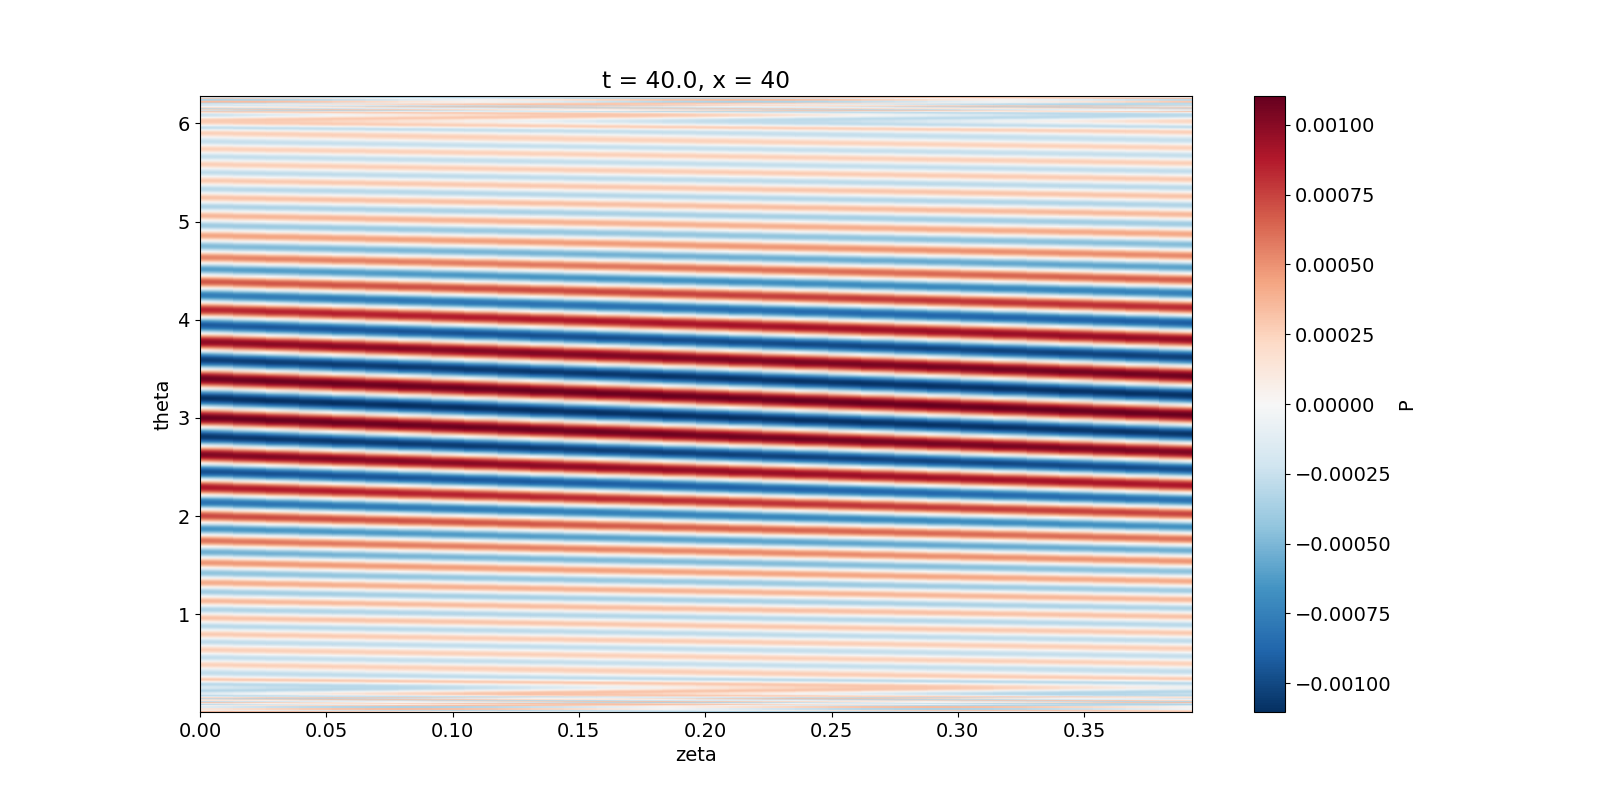

In [13]:
plt.figure()
ds_highres["P"].isel(t=-1, x=40).plot(shading="gouraud", infer_intervals=False)

It may be useful to transform to field-aligned coordinates to
examine the structure of the mode.

<IPython.core.display.Javascript object>


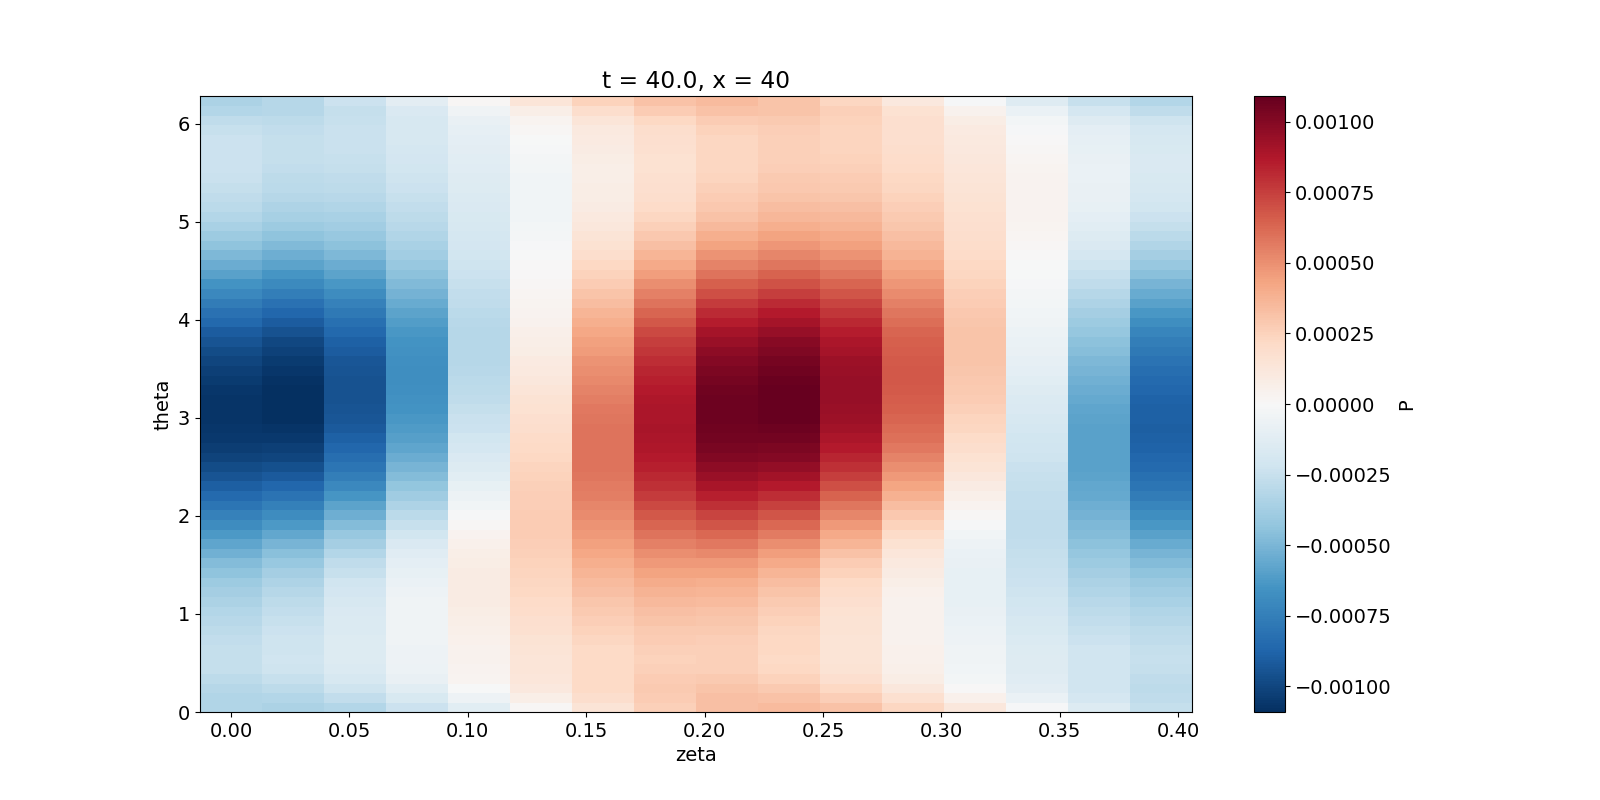

In [14]:
plt.figure()
ds["P"].bout.to_field_aligned().isel(t=-1, x=40).plot()

`xarray` provides many useful methods for analysis, mostly based
on `numpy` but with a more human-readable interface.

For example here we find spatial maximum to track the growth of the
mode.

<IPython.core.display.Javascript object>


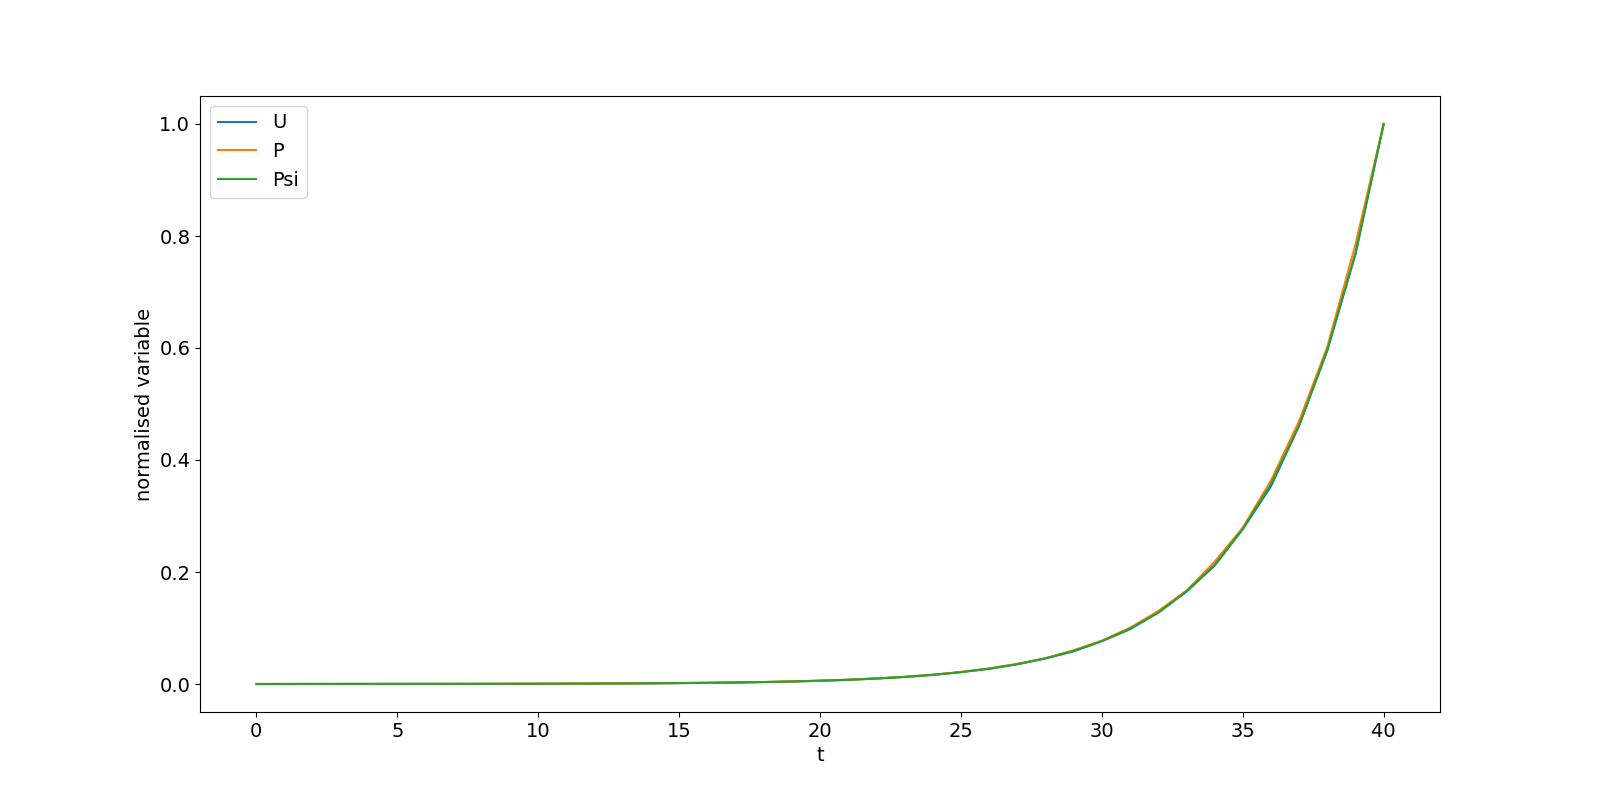

In [15]:
plt.figure() 
for var in ["U", "P", "Psi"]:
    varmax = ds[var].max(dim=["x", "theta", "zeta"])
    varmax = varmax / varmax.isel(t=-1)
    varmax.plot(label=var)
plt.ylabel("normalised variable")
plt.legend()

Animate
=======

Animations need to be interactive, so only show a frozen image in a saved notebook. Please download and run the notebook to see the animations

A radial-toroidal plane

In [ ]:
ds.isel(theta=32).bout.animate_list(["U", "P", "Psi"], ncols=3, logscale=True)

A poloidal plane

In [ ]:
ds.isel(zeta=0).bout.animate_list(["U", "P", "Psi"], ncols=3, poloidal_plot=True)

A poloidal plot, using the interpolated Dataset to get high resolution.

Animations can be saved by passing a 'save_as' argument giving a name
for the output file.

In [ ]:
ds_highres.isel(zeta=0).bout.animate_list(["U", "P", "Psi"], ncols=3, poloidal_plot=True, save_as="poloidal_plot")

`shading="gouraud"` can be used with animations too

In [ ]:
ds_highres.isel(zeta=0).bout.animate_list(["U", "P", "Psi"], ncols=3, poloidal_plot=True, shading="gouraud")

Extras
=====

We can create a new coordinate and use it for plotting.

As an example, we create `psi_N`, and then combine with toroidal angle.

In [16]:
# open grid file to get some extra variables
grid = open_boutdataset("cbm18_dens8.grid_nx68ny64.nc", info=False)
psi_axis = grid.metadata["psi_axis"]
psi_bndry = grid.metadata["psi_bndry"]

psi_N = (ds["psi_poloidal"] - psi_axis)/(psi_bndry - psi_axis)
ds = ds.assign_coords(psi_N=psi_N)

# Extra coordinates to make a toroidal plot
ds = ds.assign_coords(xtilde=ds["psi_N"]*np.cos(ds["zeta"]), ytilde=ds["psi_N"]*np.sin(ds["zeta"]))

With the new coordinates we can make a 'toroidal' plot of a
radial-toroidal plane.
The simulation uses `zperiod=15`, so this is 1/15 of an annulus.

<IPython.core.display.Javascript object>


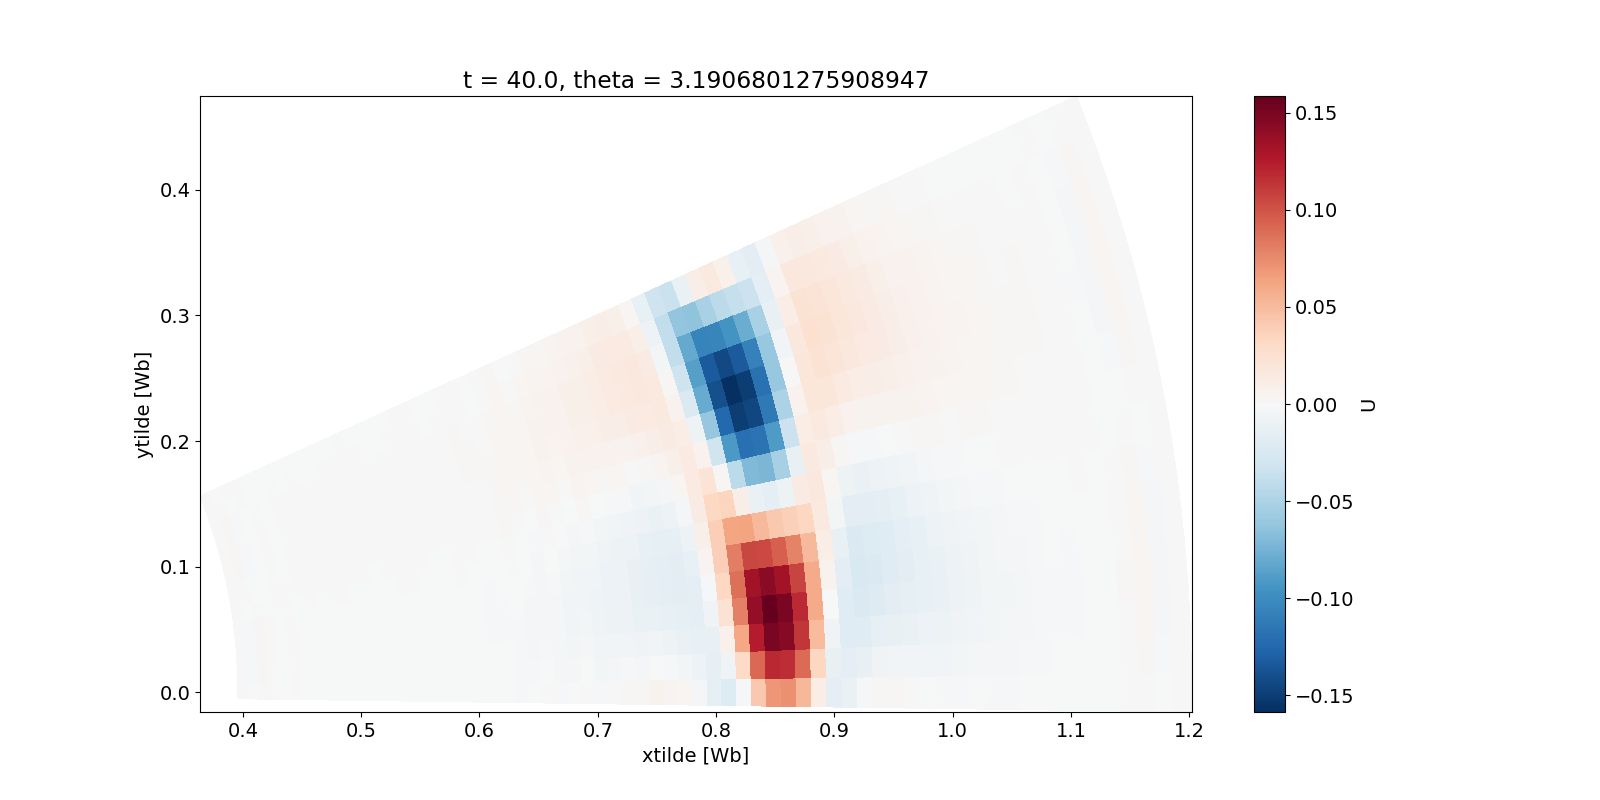

In [17]:
plt.figure()
ds["U"].isel(t=-1, theta=32).plot(x="xtilde", y="ytilde")